In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import BertTokenizer, AutoModelForSequenceClassification, BertTokenizer, get_scheduler
from datasets import load_from_disk
from torch.optim import AdamW
import os
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/home/asif/anaconda3/envs/bekoron/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model = AutoModelForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base")
tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

**Prepare Data For Training**

In [8]:
dataset = load_from_disk("/home/asif/bekoron/duplicate-remover/duplicate_tokenized_dataset")

In [9]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1248821
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 138656
    })
})


In [10]:
train_dataset = dataset["train"].shuffle(seed=42).select(range(1248821))
eval_dataset = dataset["validation"].shuffle(seed=42).select(range(138656))

Loading cached shuffled indices for dataset at /home/asif/bekoron/duplicate-remover/duplicate_tokenized_dataset/train/cache-413b9c71c548b620.arrow
Loading cached shuffled indices for dataset at /home/asif/bekoron/duplicate-remover/duplicate_tokenized_dataset/validation/cache-2aade1dc291a792e.arrow


In [11]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

In [12]:
optimizer = AdamW(model.parameters(), lr=5e-5)

In [13]:
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader) 
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [14]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

**Training Loop**

In [15]:
num_epochs = 5
progress_bar = tqdm(range(num_training_steps))

best_val_accuracy = 0.0
patience_counter = 0
early_stopping_patience = 3

model.train()
for epoch in range(num_epochs):
    # Training
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Validation
    model.eval()
    val_accuracy = 0.0
    with torch.no_grad():
        for val_batch in eval_dataloader:
            val_batch = {k: v.to(device) for k, v in val_batch.items()}
            val_outputs = model(**val_batch)
            val_logits = val_outputs.logits
            val_predictions = torch.argmax(val_logits, dim=1)
            val_labels = val_batch['labels']
            val_accuracy += torch.sum(val_predictions == val_labels).item()

    val_accuracy /= len(eval_dataset)
    print(f"Epoch {epoch}, validation accuracy: {val_accuracy:.4f}")

    # Save model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        torch.save(model.state_dict(), 'duplicate_remover.pt')
        best_val_accuracy = val_accuracy
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping callback
    if patience_counter >= early_stopping_patience:
        print(f"No improvement in validation accuracy for {early_stopping_patience} epochs. Training stopped.")
        break

    model.train()


 20%|██        | 39026/195130 [3:24:27<13:18:42,  3.26it/s]

Epoch 0, validation accuracy: 0.9210


 40%|████      | 78052/195130 [6:57:21<10:00:51,  3.25it/s]   

Epoch 1, validation accuracy: 0.9254


 60%|██████    | 117078/195130 [10:31:02<6:31:39,  3.32it/s]  

Epoch 2, validation accuracy: 0.9359


 80%|████████  | 156104/195130 [14:04:17<3:22:05,  3.22it/s]    

**Inference**

In [4]:
model = AutoModelForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base")

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [10]:
model.load_state_dict(torch.load("/home/asif/bekoron/duplicate-remover/duplicate_remover.pt"))

<All keys matched successfully>

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [6]:
tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

In [28]:
# replace TEXT_TO_CLASSIFY with the text you want to classify
text = "আমার খুব ভয় করে করে ওখানে যেতে"

tokenized_text = tokenizer.tokenize(text)

# convert the tokens to IDs
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# create a PyTorch tensor from the IDs
tokens_tensor = torch.tensor([indexed_tokens])

# optional: if your model uses GPU, move the tensor to the GPU
if torch.cuda.is_available():
    tokens_tensor = tokens_tensor.to('cuda')

In [29]:
# get the model's prediction
with torch.no_grad():
    outputs = model(tokens_tensor)

# convert the output to probabilities
probs = nn.functional.softmax(outputs[0], dim=-1)

# get the predicted class (the class with the highest probability)
predicted_class = torch.argmax(probs).item()

# print the predicted class
print(predicted_class)

1


**Test Accuracy**

In [32]:
test_data = load_from_disk("/home/asif/bekoron/duplicate-remover/duplicate_tokenized_dataset_test")

In [35]:
test_dataset = test_data["test"]

In [41]:
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [42]:
test_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 70000
})

In [45]:
progress_bar = tqdm(range(len(test_dataloader)))
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    for val_batch in test_dataloader:
        val_batch = {k: v.to(device) for k, v in val_batch.items()}
        val_outputs = model(**val_batch)
        val_logits = val_outputs.logits
        val_predictions = torch.argmax(val_logits, dim=1)
        val_labels = val_batch['labels']
        test_accuracy += torch.sum(val_predictions == val_labels).item()
        progress_bar.update(1)
        
test_accuracy /= len(test_dataset)
print(f" testing accuracy: {test_accuracy:.4f}")

  0%|          | 0/2188 [01:04<?, ?it/s]


 testing accuracy: 0.9518


**Classification Report**

In [58]:
model.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for val_batch in test_dataloader:
        val_batch = {k: v.to(device) for k, v in val_batch.items()}
        val_outputs = model(**val_batch)
        val_logits = val_outputs.logits
        val_predictions = torch.argmax(val_logits, dim=1)
        predicted_labels += val_predictions.cpu().numpy().tolist()
        true_labels += val_batch["labels"].cpu().numpy().tolist()
        progress_bar.update(1)

100%|██████████| 2188/2188 [13:40<00:00,  9.42it/s]  

In [59]:
# Generate the classification report
print(classification_report(true_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.95      0.96      0.95     35000
           1       0.95      0.95      0.95     35000

    accuracy                           0.95     70000
   macro avg       0.95      0.95      0.95     70000
weighted avg       0.95      0.95      0.95     70000



In [61]:
print(confusion_matrix(true_labels, predicted_labels))

[[33432  1568]
 [ 1806 33194]]


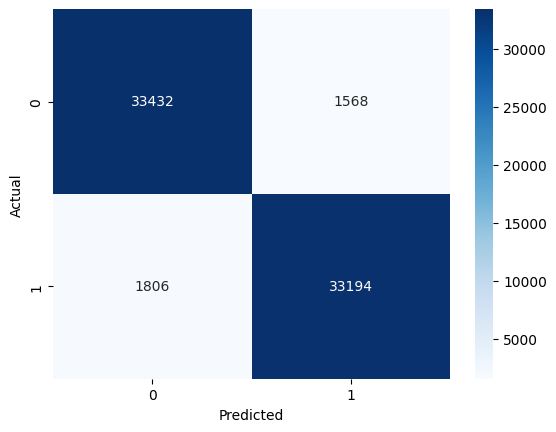

In [1]:
# confusion_matrix = np.array([[33432, 1568], [1806, 33194]])
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()